In [1]:
#Importing
#!conda install geopandas --y

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import tensorflow as tf
import geopandas as gpd

from shapely.geometry import Point

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score)
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.utils import to_categorical

In [2]:
#Importing Data
data = pd.read_csv("data/ACLED2021-2024.csv")

location_data = data.copy()

data.drop(columns=['time_precision', 'assoc_actor_1', 'assoc_actor_2', 'iso', 'region', 'admin3', 'location', 
                   'geo_precision', 'source_scale', 'timestamp', 'tags', 'population_best', 'event_id_cnty'], 
          inplace=True)

print(data.shape)


data['event_date'] = pd.to_datetime(data['event_date'], errors = 'coerce') #changing to datetime

#data.set_index('event_date', inplace=True)
#data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

print(data.shape)
#data = data.dropna(subset=['event_date'])

(38130, 19)
(38130, 19)


In [3]:
# Dropping Dupes
initial_row_count = data.shape[0]
data = data.drop_duplicates()
final_row_count = data.shape[0]
print(f"Removed {initial_row_count - final_row_count} duplicates")
print(data.shape)

Removed 5 duplicates
(38125, 19)


In [4]:
#Reformatting / Cleaning

#Addressing NA values - Categorical, NUmerical and date
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting', 
                       'country', 'admin1', 'admin2', 'source', 'notes']
categorical_columns = data[categorical_columns]


for column in categorical_columns:
    data[column] = data[column].fillna('Not specified')

numerical_columns = ['fatalities', 'inter1', 'inter2', 'interaction', 'latitude', 'longitude',]

for column in numerical_columns:
    data[column] = data[column].fillna(data[column].median()) #using median to fill
    
#print(data.isna().sum())
print(data.shape)
#data.loc[:, 'actor2'] = data['actor2'].fillna('Not specified')
#data.loc[:, 'civilian_targeting'] = data['civilian_targeting'].fillna('Not specified')

(38125, 19)


In [5]:
#Grouping Together Actor1 and 2
def consolidate_names(name):
    if 'Military Forces of Israel' in name:
        return 'Military Forces of Israel'
    elif 'Police Forces of Israel' in name:
        return 'Police Forces of Israel'
    elif 'Hamas Movement' in name:
        return 'Hamas Movement'
    elif 'Police Forces of Israel' in name or 'Government of Israel' in name:
        return 'Government and Police Forces of Israel'
    elif 'Police Forces of Palestine' in name or 'Government of Palestine' in name:
        return 'Government and Police Forces of Palestine'
    elif 'PIJ:' in name or 'Islamic Jihad' in name:
        return 'Palestinian Islamic Jihad'
    elif 'Hezbollah' in name:
        return 'Hezbollah'
    elif 'Al Aqsa' in name:
        return 'Al Aqsa Martyrs Brigade'
    elif 'Katibat' in name:
        return 'Katibat Groups (Palestine)'
    elif 'PFLP:' in name:
        return 'Popular Front for the Liberation of Palestine'
    elif 'DFLP:' in name:
        return 'Democratic Front for the Liberation of Palestine'
    elif 'Military Forces of Iran' in name:
        return 'Iranian Revolutionary Guard Corps'
    elif 'Islamic State' in name:
        return 'Islamic State'
#civilians
    elif 'Civilians' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  #Keeping isr and pal civilians
        else:
            return 'Civilians (International)'  # grouping others as int.
#armed groups
    elif 'Unidentified Armed Group' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Unidentified Armed Group (International)'
#military forces
    elif 'Military Forces of' in name:
        if 'Israel' in name or 'Palestine' in name:
            return name  
        else:
            return 'Military Forces of International Forces'
    elif 'Settlers' in name:
        return 'Settlers (Israel)'
    elif 'Protesters' in name or 'Rioters' in name:
        return name  # Retains specific categories due to their distinct contexts
    else:
        return name #'Other Groups' 

# Apply the consolidation function to both actor1 and actor2
data['actor1_grouped'] = data['actor1'].apply(consolidate_names)
data['actor2_grouped'] = data['actor2'].apply(consolidate_names)

In [6]:
#Grouping smaller entities
actor1_counts = data['actor1_grouped'].value_counts()
actor2_counts = data['actor2_grouped'].value_counts()

def consolidate_small_groups(name, counts): #Check if Isr or Pal if not 'name'
    if counts[name] < 10:
        if 'Israel' in name:
            return 'Other (Israel)'
        elif 'Palestine' in name:
            return 'Other (Palestine)'
        else:
            return'Other Group'
    else:
        # Return the name if the count is 10 or more
        return name

# Apply the consolidation function to both actor1_grouped and actor2_grouped
data['actor1_grouped'] = data['actor1_grouped'].apply(lambda x: consolidate_small_groups(x, actor1_counts))
data['actor2_grouped'] = data['actor2_grouped'].apply(lambda x: consolidate_small_groups(x, actor2_counts))


# Print the new value counts to confirm re-categorization
#print(data['actor1_grouped'].value_counts())
#print(data['actor2_grouped'].value_counts())

data['actor1'] = data['actor1_grouped']
data['actor2'] = data['actor2_grouped']

data.drop(['actor1_grouped', 'actor2_grouped'], axis=1, inplace=True)
print(data.isna().sum())
# calculate the percentage of zero values per column
zero_counts = (data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(data)

# display the columns with high percentages of zeros
print("Percentage of zeros in each column:")
print(zero_percentage[zero_percentage > 0])  # Adjust the threshold as necessary


event_date            0
year                  0
disorder_type         0
event_type            0
sub_event_type        0
actor1                0
inter1                0
actor2                0
inter2                0
interaction           0
civilian_targeting    0
country               0
admin1                0
admin2                0
latitude              0
longitude             0
source                0
notes                 0
fatalities            0
dtype: int64
Percentage of zeros in each column:
inter2        27.255082
fatalities    91.045246
dtype: float64


In [7]:
#Creating Temporal Features for T-S

#Date related
data['year'] = data['event_date'].dt.year
data['month'] = data['event_date'].dt.month
data['day'] = data['event_date'].dt.day
data['day_of_week'] = data['event_date'].dt.day_name()
data['days_since_start'] = (data['event_date'] - data['event_date'].min()).dt.days

# time since last event of the same type
data['time_since_last_event'] = data.groupby('event_type')['event_date'].diff().dt.days
#data['time_since_last_event'] = data.groupby('event_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)


# time since last disorder of the same type
data['time_since_last_disorder'] = data.groupby('disorder_type')['event_date'].diff().dt.days
#data['time_since_last_disorder'] = data.groupby('disorder_type').apply(lambda x: x.index.to_series().diff().dt.days).reset_index(level=0, drop=True)
#print(data[['time_since_last_event', 'time_since_last_disorder']].head())


# rolling avg for fatalities
data['rolling_avg_fatalities_7d'] = data.groupby(
    'event_type')['fatalities'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


# cumulative counts of events and fatalities by specific features
data['cumulative_events'] = data.groupby(['event_type']).cumcount() + 1
data['cumulative_fatalities'] = data.groupby(['event_type'])['fatalities'].cumsum()

log_data = data.copy()


<Figure size 1500x800 with 0 Axes>

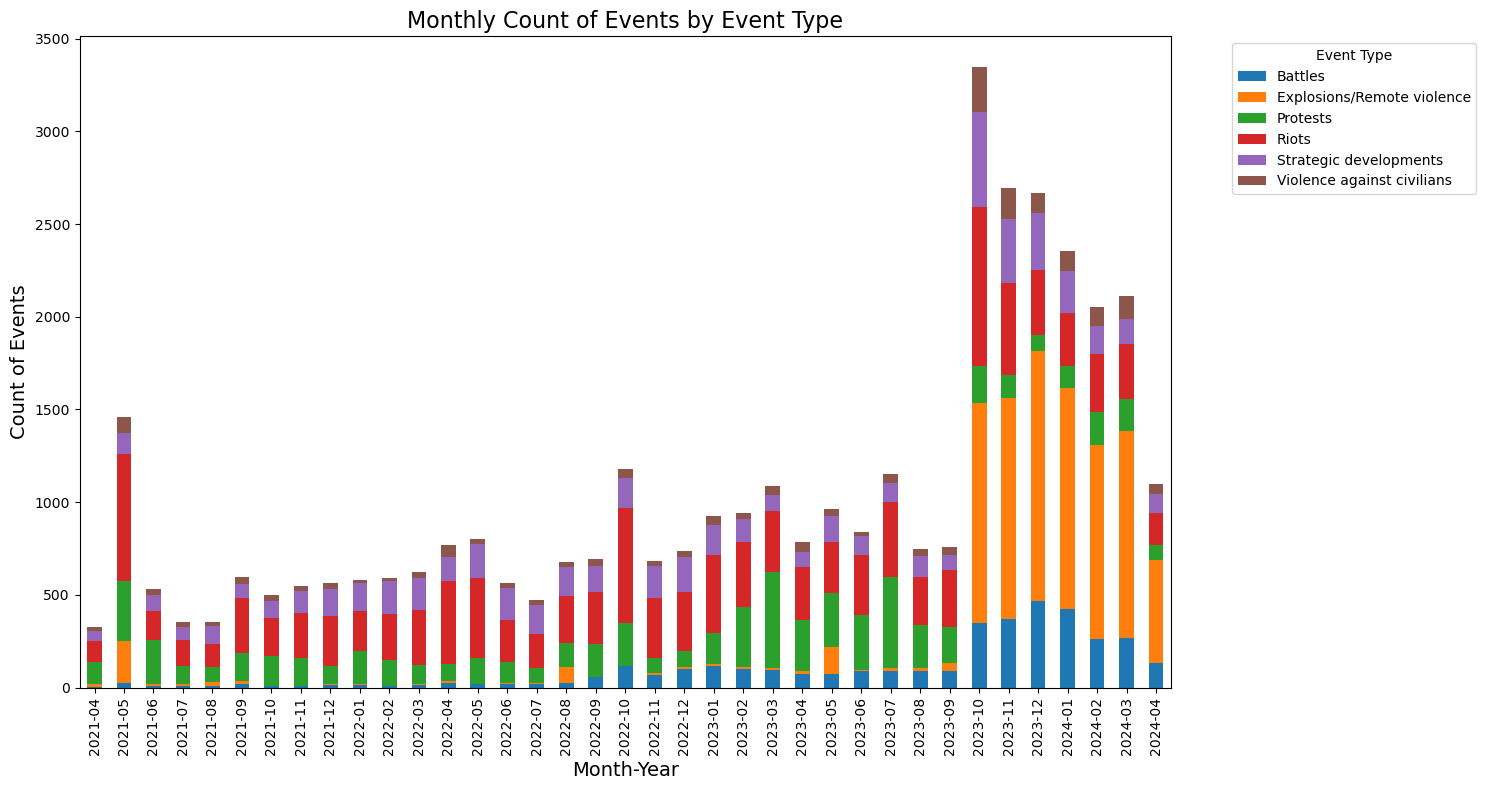

In [8]:
# Plotting the count of events over time by event_type
data['month_year'] = data['event_date'].dt.to_period('M') #group data into month

# countplot with monthly data
plt.figure(figsize=(15, 8))
monthly_data = data.groupby(['month_year', 'event_type']).size().reset_index(name='counts')

#creating'event_type' columns
monthly_pivot = monthly_data.pivot(index='month_year', columns='event_type', values='counts').fillna(0)

monthly_pivot.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Monthly Count of Events by Event Type', fontsize=16)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Count of Events', fontsize=14)
plt.xticks(rotation=90)
plt.legend(title='Event Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

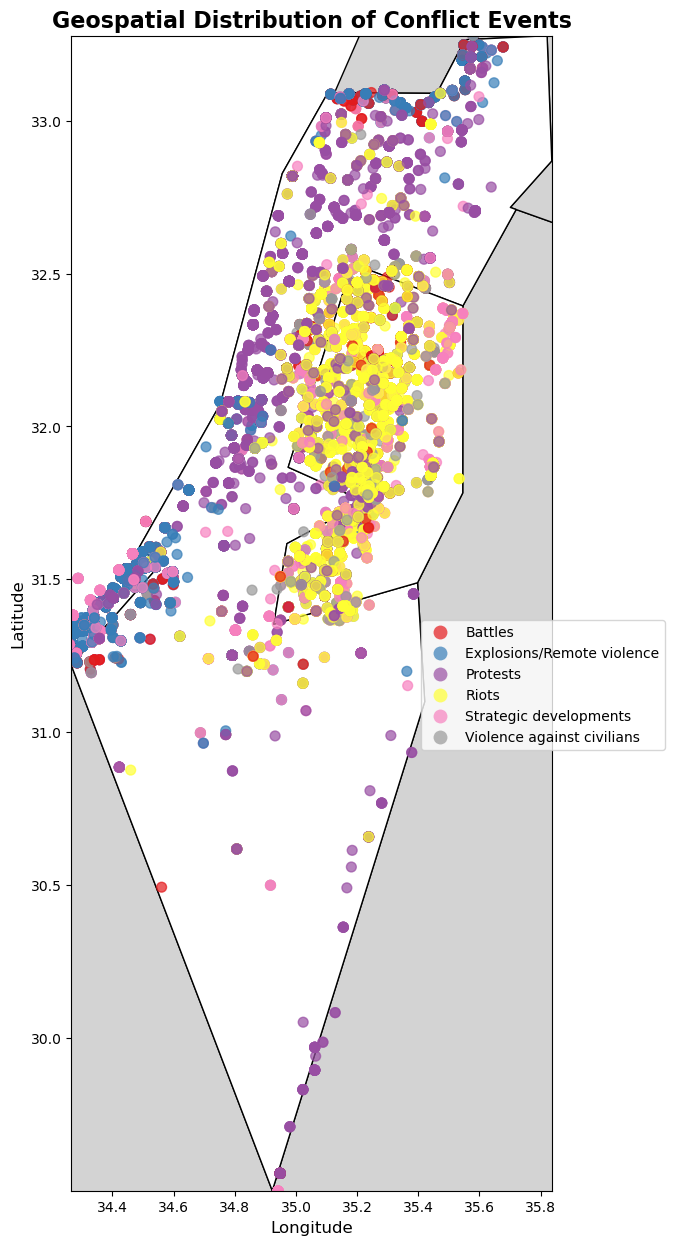

In [9]:
geometry = [Point(xy) for xy in zip(location_data.longitude, location_data.latitude)]
geo_df = gpd.GeoDataFrame(location_data, geometry=geometry)

fig, ax = plt.subplots(1, 1, figsize=(12, 15))

# Load a world map shapefile and plot the world in a light grey
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot Israel and Palestine with a clear edge
isr_pal = world[(world.name == "Israel") | (world.name == "Palestine")]
isr_pal.plot(ax=ax, color='white', edgecolor='black')

geo_df.plot(ax=ax, column='event_type', legend=True, markersize=50, cmap='Set1', alpha=0.7)

leg = ax.get_legend()
if leg:  
    leg.set_bbox_to_anchor((1.25, 0.5))

# Set the limits to frame the region of interest
plt.xlim(isr_pal.bounds.minx.min(), isr_pal.bounds.maxx.max())
plt.ylim(isr_pal.bounds.miny.min(), isr_pal.bounds.maxy.max())

# Set title and axis labels
plt.title('Geospatial Distribution of Conflict Events', fontsize=16, weight='bold')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Remove axis for a cleaner look
plt.axis('on')

# Show the plot
plt.show()

In [10]:
#log transformations
log_columns = ['fatalities', 'cumulative_events', 'cumulative_fatalities', 'rolling_avg_fatalities_7d', 
               'time_since_last_event', 'time_since_last_disorder', 'days_since_start']
for col in log_columns:
    log_data['log_' + col] = np.log1p(log_data[col])

# creating lagged features
for col in log_columns:
    log_col = 'log_' + col
    for lag in [1, 2, 3]:
        log_data[f'{log_col}_lag{lag}'] = log_data[log_col].shift(lag)

/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
log_data

,event_date,year,disorder_type,event_type,sub_event_type,actor1,inter1,actor2,inter2,interaction,...,log_rolling_avg_fatalities_7d_lag3,log_time_since_last_event_lag1,log_time_since_last_event_lag2,log_time_since_last_event_lag3,log_time_since_last_disorder_lag1,log_time_since_last_disorder_lag2,log_time_since_last_disorder_lag3,log_days_since_start_lag1,log_days_since_start_lag2,log_days_since_start_lag3
0,2024-04-19,2024,Political violence,Explosions/Remote violence,Shelling/artillery/missile attack,Hamas Movement,3,Not specified,0,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.999422,NaN,NaN
2,2024-04-19,2024,Demonstrations,Riots,Violent demonstration,Rioters (Israel),5,Rioters (Israel),5,55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.999422,6.999422,NaN
3,2024-04-19,2024,Demonstrations,Protests,Peaceful protest,Protesters (Israel),6,Not specified,0,60,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,6.999422,6.999422,6.999422
4,2024-04-19,2024,Political violence,Battles,Armed clash,Hezbollah,3,Military Forces of Israel,1,13,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,6.999422,6.999422,6.999422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,Strategic developments,Strategic developments,Other,Military Forces of Israel,8,Civilians (Palestine),7,78,...,0.0,0.0,-inf,0.0,0.0,-inf,0.0,0.000000,0.000000,0.000000
38126,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Not specified,0,50,...,0.0,0.0,0.0,-inf,0.0,0.0,-inf,0.000000,0.000000,0.000000
38127,2021-04-20,2021,Demonstrations,Protests,Peaceful protest,Protesters (Palestine),6,Not specified,0,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
38128,2021-04-20,2021,Political violence,Riots,Mob violence,Rioters (Israel),5,Civilians (Palestine),7,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [12]:
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])


event_date                              0
year                                    0
disorder_type                           0
event_type                              0
sub_event_type                          0
actor1                                  0
inter1                                  0
actor2                                  0
inter2                                  0
interaction                             0
civilian_targeting                      0
country                                 0
admin1                                  0
admin2                                  0
latitude                                0
longitude                               0
source                                  0
notes                                   0
fatalities                              0
month                                   0
day                                     0
day_of_week                             0
days_since_start                        0
time_since_last_event             

In [13]:
#replacing infinities w NaN
log_data.replace([np.inf, -np.inf], np.nan, inplace=True)
#log_data.fillna(log_data.median(), inplace=True)

#median for numeric columns
numeric_medians = log_data.select_dtypes(include=[np.number]).median()
log_data.fillna(numeric_medians, inplace=True)


log_data['time_since_last_event'].fillna(method='ffill', inplace=True)
log_data['time_since_last_event'].fillna(method='bfill', inplace=True)

lag_cols = [col for col in log_data.columns if ('log_time_since_last_event' in col or 'lag' in col) and 
            np.issubdtype(log_data[col].dtype, np.number)]

In [14]:
print(log_data.shape)
print(log_data.isna().sum())

# percentage of zero values
zero_counts = (log_data == 0).astype(int).sum(axis=0)
zero_percentage = 100 * zero_counts / len(log_data)
print(zero_percentage[zero_percentage > 0])

(38125, 56)
event_date                            0
year                                  0
disorder_type                         0
event_type                            0
sub_event_type                        0
actor1                                0
inter1                                0
actor2                                0
inter2                                0
interaction                           0
civilian_targeting                    0
country                               0
admin1                                0
admin2                                0
latitude                              0
longitude                             0
source                                0
notes                                 0
fatalities                            0
month                                 0
day                                   0
day_of_week                           0
days_since_start                      0
time_since_last_event                 0
time_since_last_disorder    

In [15]:
#Encoding

#One-Hot for Categoricals
categorical_cols = ['disorder_type', 'sub_event_type', 'actor1', 'actor2', 'civilian_targeting',
                    'country', 'admin1', 'admin2', 'day_of_week']
log_data_encoded = pd.get_dummies(log_data, columns=categorical_cols)
log_data_encoded

#Label Encoder
label_encoders = {}

for col in ['inter1', 'inter2', 'interaction', 'event_type']:
    le = LabelEncoder()
    log_data_encoded[col] = le.fit_transform(log_data_encoded[col])
    label_encoders[col] = le  # storing the encoder
#log_data_encoded.to_csv('data/log_data_encoded.csv', index=False)
#print(log_data_encoded.isna().sum())

In [16]:
log_data_encoded

,event_date,year,event_type,inter1,inter2,interaction,latitude,longitude,source,notes,...,admin2_Tulkarm,admin2_Yizreel,admin2_Zefat,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,2024-04-19,2024,1,2,0,9,31.5250,34.5969,N12; Times of Israel,"Interception: On 19 April 2024, Hamas militant...",...,False,False,False,True,False,False,False,False,False,False
1,2024-04-19,2024,2,5,0,21,32.6363,34.9324,Ynet,"On 19 April 2024, thousands formed a human cha...",...,False,False,False,True,False,False,False,False,False,False
2,2024-04-19,2024,3,4,4,17,31.8766,34.9205,Haaretz; Jerusalem Post; N12; Times of Israel;...,"On 19 April 2024, dozens of relatives of hosta...",...,False,False,False,True,False,False,False,False,False,False
3,2024-04-19,2024,2,5,0,21,31.9710,34.7894,Ynet,"On 19 April 2024, thousands formed a human cha...",...,False,False,False,True,False,False,False,False,False,False
4,2024-04-19,2024,0,2,1,3,33.1288,35.5523,Jerusalem Post; Ma'ariv; Times of Israel,"On 19 April 2024, Hezbollah forces in Lebanon ...",...,False,False,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38125,2021-04-20,2021,4,7,6,26,31.5839,34.4659,PLO Negotiations Affairs Department,"Other: On 20 April 2021, Israeli military forc...",...,False,False,False,False,False,False,False,False,True,False
38126,2021-04-20,2021,3,4,0,16,31.5159,35.1639,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers uprooted 20...",...,False,False,False,False,False,False,False,False,True,False
38127,2021-04-20,2021,2,5,0,21,31.4178,34.3503,Ma'an News Agency,"On 20 April 2021, a large protest organized by...",...,False,False,False,False,False,False,False,False,True,False
38128,2021-04-20,2021,3,4,6,19,31.9333,35.2167,PLO Negotiations Affairs Department,"On 20 April 2021, Israeli settlers from the Ba...",...,False,False,False,False,False,False,False,False,True,False


In [17]:
# Correlation Analysis for numerical cols
numerical_cols = log_data_encoded.select_dtypes(include=['int64', 'float64']).columns
numerical_data = log_data_encoded[numerical_cols]
correlation_matrix = numerical_data.corr()

threshold = 0.85
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
to_drop

['interaction',
 'log_rolling_avg_fatalities_7d',
 'log_days_since_start',
 'log_days_since_start_lag1',
 'log_days_since_start_lag2',
 'log_days_since_start_lag3']

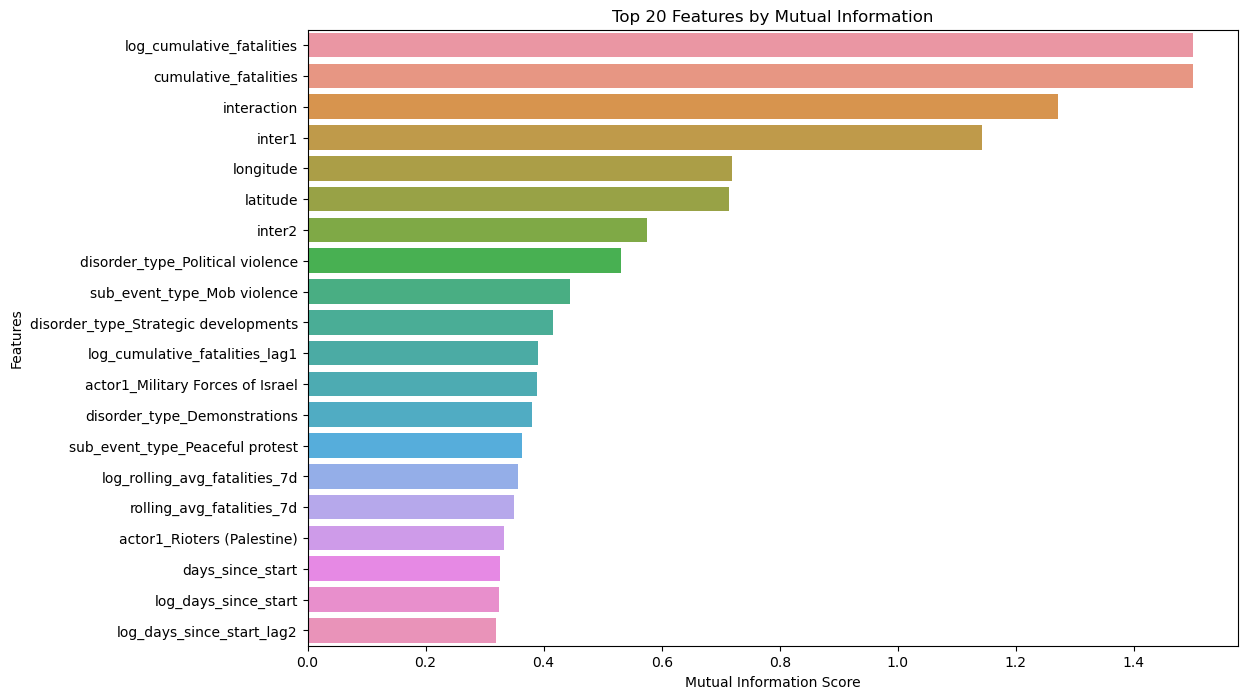

In [18]:
#Mututal Information features

target = 'event_type'

# taking out the text + datetime
features = log_data_encoded.drop(columns=[target, 'event_date', 'source', 'notes'])

# actual mi score calculation
mi_scores = mutual_info_classif(features, log_data_encoded[target], discrete_features='auto')

# putting in df
mi_df = pd.DataFrame({'Feature': features.columns, 'MI_Score': mi_scores})
mi_df.sort_values('MI_Score', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='MI_Score', y='Feature', data=mi_df.sort_values('MI_Score', ascending=False).head(20))
plt.title('Top 20 Features by Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

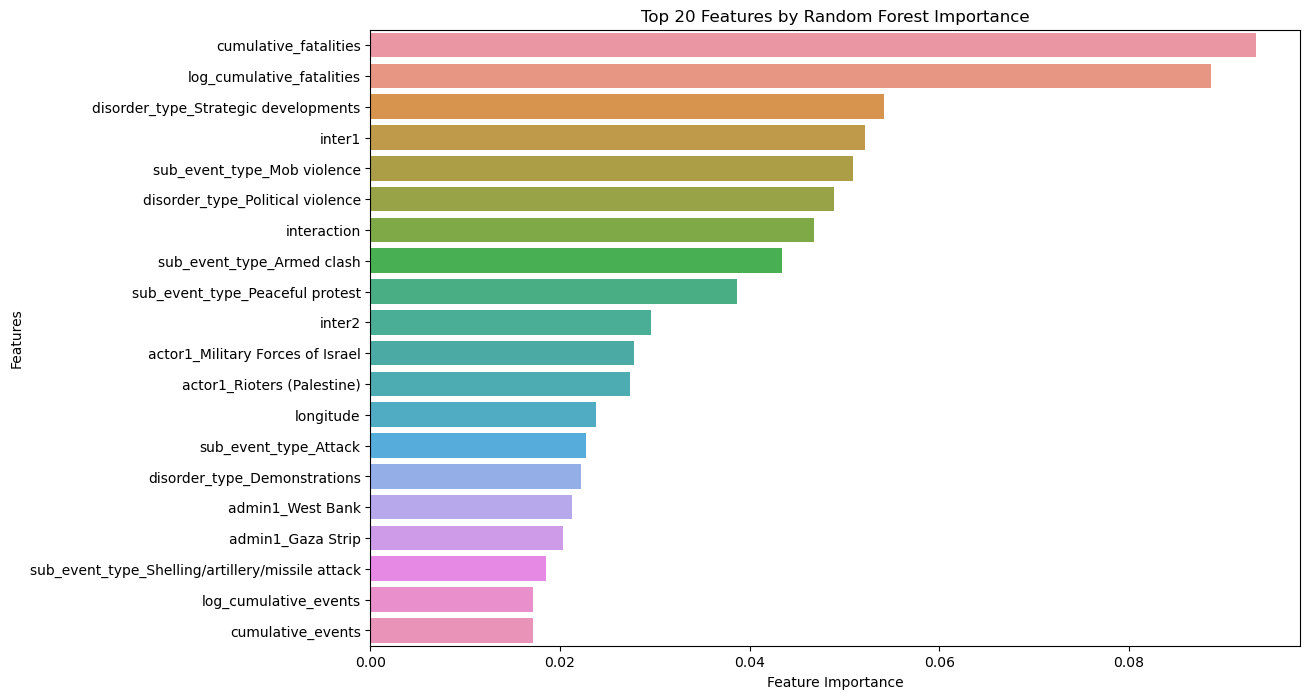

In [19]:
#Random Forest Importance
#numeric_encoded_log_data
#Dropping numeric + T/T Splitting
X = log_data_encoded.drop(['event_type',  'event_date', 'source', 'notes'], axis=1)
y = log_data_encoded['event_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

# feature importances into df
importances = forest.feature_importances_

rf_df = pd.DataFrame({'Feature': X_train.columns, 'RF_Importance': importances})
rf_df.sort_values('RF_Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='RF_Importance', y='Feature', data=rf_df.sort_values('RF_Importance', ascending=False).head(20))
plt.title('Top 20 Features by Random Forest Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

In [20]:
print(mi_df.shape)
print(rf_df.shape)

(167, 2)
(167, 2)


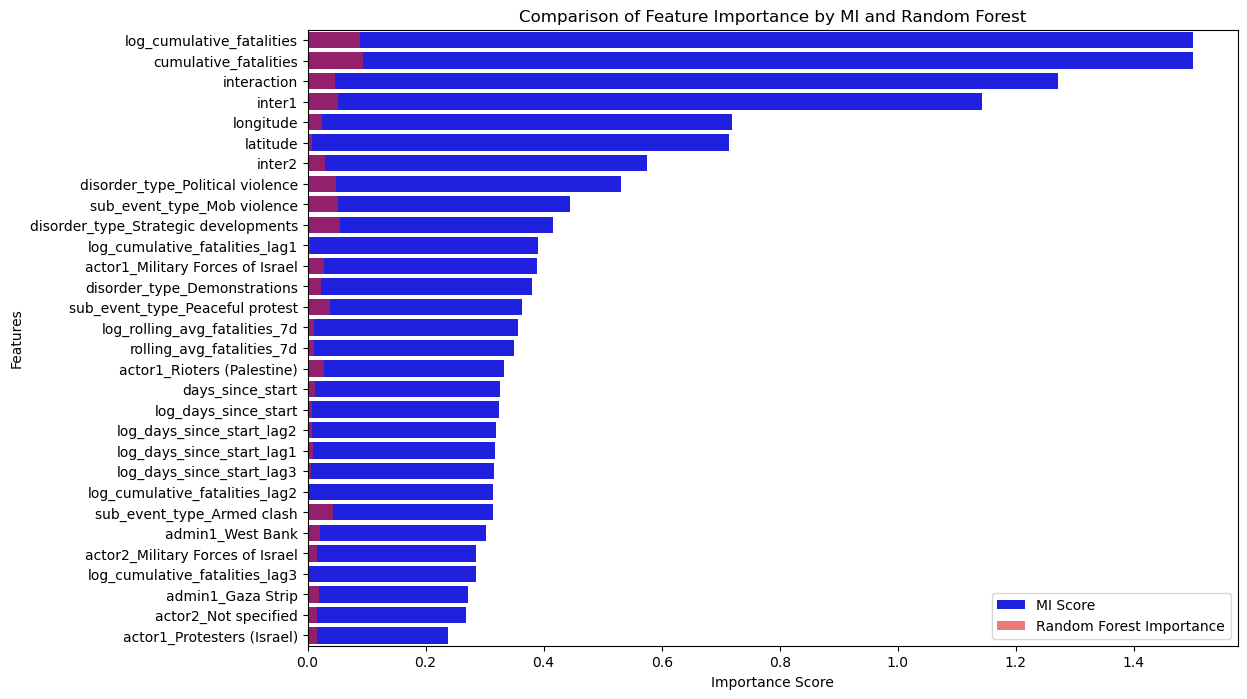

In [21]:
rf_df = pd.DataFrame({'Feature': X_train.columns,
                                    'RF_Importance': forest.feature_importances_})

#merging datasets
combined_importances = pd.merge(mi_df, rf_df, on='Feature', how='outer')

combined_importances.sort_values(by='MI_Score', ascending=False, inplace=True)

combined_importances = pd.merge(mi_df, rf_df, on='Feature', how='outer')

#set the amount of feaatures
sorted_idx = combined_importances.sort_values(by='MI_Score', ascending=False)['Feature'].head(30)


plt.figure(figsize=(12, 8))
sns.barplot(x='MI_Score', y='Feature', data=combined_importances[combined_importances['Feature'].isin(sorted_idx)], 
            color='blue', label='MI Score')
sns.barplot(x='RF_Importance', y='Feature', data=combined_importances[combined_importances['Feature'].isin(sorted_idx)], 
            color='red', alpha=0.6, label='Random Forest Importance')
plt.title('Comparison of Feature Importance by MI and Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.legend()
plt.show()


In [22]:
# MI score
mi_percentile = 70  # aka keeping top 50%
mi_threshold = np.percentile(mi_df['MI_Score'], mi_percentile)
#top_mi_features = mi_df[mi_df['MI_Score'] >= mi_threshold]
selected_mi_features = mi_df[mi_df['MI_Score'] >= mi_threshold]['Feature'].tolist()
#top_mi_features.shape
#print(selected_mi_features)

# random forest importance
rf_percentile = 70  # aka keeping top 50% | top 30% is 43 features
rf_threshold = np.percentile(rf_df['RF_Importance'], rf_percentile)
#top_rf_features = rf_df[rf_df['RF_Importance'] >= rf_threshold]
selected_rf_features = rf_df[rf_df['RF_Importance'] >= 
                                      rf_threshold]['Feature'].tolist()
#top_rf_features.shape
#print(selected_rf_features)

#Combining into 1
selected_features = list(set(selected_mi_features) & set(selected_rf_features))

In [23]:
print(selected_features)

['log_cumulative_fatalities', 'sub_event_type_Attack', 'disorder_type_Strategic developments', 'cumulative_fatalities', 'log_cumulative_fatalities_lag1', 'log_cumulative_events_lag3', 'latitude', 'log_days_since_start_lag1', 'admin1_West Bank', 'log_rolling_avg_fatalities_7d', 'log_days_since_start_lag3', 'actor1_Military Forces of Israel', 'sub_event_type_Peaceful protest', 'days_since_start', 'log_days_since_start', 'actor2_Military Forces of Israel', 'actor1_Rioters (Israel)', 'log_cumulative_events', 'civilian_targeting_Not specified', 'actor1_Rioters (Palestine)', 'log_days_since_start_lag2', 'rolling_avg_fatalities_7d', 'admin1_Gaza Strip', 'inter1', 'actor2_Civilians (Palestine)', 'log_cumulative_fatalities_lag2', 'longitude', 'actor2_Not specified', 'disorder_type_Demonstrations', 'civilian_targeting_Civilian targeting', 'country_Palestine', 'interaction', 'sub_event_type_Air/drone strike', 'country_Israel', 'sub_event_type_Looting/property destruction', 'inter2', 'sub_event_ty

In [24]:
print(len(selected_features))
print(len(set(selected_features))) #unique


44
44


In [25]:
log_data_encoded = log_data_encoded.apply(lambda col: col.astype(int) if pd.api.types.is_bool_dtype(col) else col) 
#SO IMPORTANT! changes values of bool to int

In [26]:
#Selected Features
X_selected = log_data_encoded[selected_features].copy()
y = log_data_encoded['event_type']

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, shuffle=False)

y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_test_encoded = tf.keras.utils.to_categorical(y_test)

In [27]:
#X_train = X_train.astype({col: 'int64' for col in X_train.columns if X_train[col].dtype == 'bool'})
#X_test = X_test.astype({col: 'int64' for col in X_test.columns if X_test[col].dtype == 'bool'})
print(X_train.shape)
print(X_train.shape)
print(y_train.shape)
print(y_test.shape)
print("Encoded Y")
print(y_train_encoded.shape)
print(y_test_encoded.shape)
#print(X_train.dtypes)

(30500, 44)
(30500, 44)
(30500,)
(7625,)
Encoded Y
(30500, 6)
(7625, 6)


In [28]:
#print(X_selected_train.head())
#print(y_train.head())
#print(y_train_encoded)

In [29]:
#Decision Tree Baseline

tree_classifier = DecisionTreeClassifier(random_state=42)

tree_classifier.fit(X_train, y_train_encoded)

tree_predictions = tree_classifier.predict(X_test)

tree_accuracy = accuracy_score(y_test_encoded, tree_predictions)
tree_classification_report = classification_report(y_test_encoded, tree_predictions)
print(f"Accuracy of Decision Tree: {tree_accuracy:.2f}")
print(tree_classification_report)

Accuracy of Decision Tree: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       161
           1       1.00      1.00      1.00       324
           2       1.00      1.00      1.00      1908
           3       1.00      1.00      1.00      3353
           4       1.00      1.00      1.00      1439
           5       1.00      1.00      1.00       440

   micro avg       1.00      1.00      1.00      7625
   macro avg       1.00      1.00      1.00      7625
weighted avg       1.00      1.00      1.00      7625
 samples avg       1.00      1.00      1.00      7625



In [30]:
# Logistic Regression

logistic_regressor = LogisticRegression(max_iter=1000, random_state=42)

logistic_regressor.fit(X_train, y_train)

logistic_predictions = logistic_regressor.predict(X_test)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_classification_report = classification_report(y_test, logistic_predictions)

print(f"Accuracy of Logistic Regression Baseline: {logistic_accuracy:.2f}")
print(logistic_classification_report)

Accuracy of Logistic Regression Baseline: 0.99
              precision    recall  f1-score   support

           0       1.00      0.34      0.51       161
           1       1.00      1.00      1.00       324
           2       1.00      1.00      1.00      1908
           3       1.00      1.00      1.00      3353
           4       1.00      1.00      1.00      1439
           5       0.81      1.00      0.89       440

    accuracy                           0.99      7625
   macro avg       0.97      0.89      0.90      7625
weighted avg       0.99      0.99      0.98      7625



/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#y_train_encoded = y_train_encoded.astype('float32')
#y_test_encoded = y_test_encoded.astype('float32')


In [32]:
#X_selected_train.dtypes

In [33]:
max_index_value = np.max(X_train)
unique_indices = len(np.unique(X_train))
print("Max index value:", max_index_value)
print("Unique indices:", unique_indices)

max_index_test = np.max(X_test)
print("Max index in X_test:", max_index_test)

Max index value: 32190.0
Unique indices: 15759
Max index in X_test: 32414.0


In [34]:
#  LSTM model
#input_dim = len(np.unique(X_selected['column_needing_embedding'])) + 1

model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=len(np.unique(y)), output_dim=100, input_length=X_train.shape[1]))
model_LSTM.add(LSTM(50, return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(50))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_LSTM.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.1)

2024-04-28 22:13:38.192605: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-04-28 22:13:38.192690: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-28 22:13:38.192701: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-28 22:13:38.193073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-28 22:13:38.193406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-04-28 22:13:40.273139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:13:40.722220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:13:41.463552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:13:43.338205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:13:44.183771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


858/858 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.8603

2024-04-28 22:14:05.774637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:14:05.850610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:14:05.898069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


858/858 [==============================] - 28s 26ms/step - loss: 0.3911 - accuracy: 0.8603 - val_loss: 0.0492 - val_accuracy: 0.9879
Epoch 2/50
858/858 [==============================] - 23s 27ms/step - loss: 0.0254 - accuracy: 0.9939 - val_loss: 0.2377 - val_accuracy: 0.9059
Epoch 3/50
858/858 [==============================] - 23s 26ms/step - loss: 0.0085 - accuracy: 0.9981 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 4/50
858/858 [==============================] - 22s 25ms/step - loss: 0.0103 - accuracy: 0.9980 - val_loss: 0.2698 - val_accuracy: 0.9275
Epoch 5/50
858/858 [==============================] - 19s 22ms/step - loss: 0.0066 - accuracy: 0.9988 - val_loss: 5.0786e-04 - val_accuracy: 1.0000
Epoch 6/50
858/858 [==============================] - 19s 23ms/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/50
858/858 [==============================] - 25s 30ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0351 - val_accuracy: 0.9770

In [35]:
loss_LSTM, accuracy_LSTM = model_LSTM.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy LSTM: {accuracy_LSTM:.2f}')

# predictions
y_pred_LSTM = model_LSTM.predict(X_test)
y_pred_classes_LSTM = np.argmax(y_pred_LSTM, axis=1)  # convert probabilities to class labels

#actual class
actual_classes_LSTM = np.argmax(y_test_encoded, axis=1) if y_test_encoded.ndim > 1 else y_test

#showing errors
errors_LSTM = np.where(y_pred_classes_LSTM != actual_classes_LSTM)[0]
print(f'Number of errors LSTM: {len(errors_LSTM)} / {len(actual_classes_LSTM)}')
for i in errors_LSTM[:10]:  # first 10 
    print(f'Index: {i}, Predicted: {y_pred_classes_LSTM[i]}, Actual: {actual_classes_LSTM[i]}')

239/239 [==============================] - 6s 26ms/step - loss: 0.0371 - accuracy: 0.9913
Test Accuracy LSTM: 0.99


2024-04-28 22:33:12.529925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:33:12.659495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  5/239 [..............................] - ETA: 3s  

2024-04-28 22:33:12.863481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 4s 12ms/step
Number of errors LSTM: 66 / 7625
Index: 1047, Predicted: 0, Actual: 3
Index: 1222, Predicted: 4, Actual: 2
Index: 2821, Predicted: 0, Actual: 3
Index: 3074, Predicted: 0, Actual: 3
Index: 3228, Predicted: 4, Actual: 3
Index: 3693, Predicted: 4, Actual: 3
Index: 3719, Predicted: 4, Actual: 3
Index: 4412, Predicted: 5, Actual: 1
Index: 4914, Predicted: 4, Actual: 3
Index: 5296, Predicted: 5, Actual: 1


In [36]:
predicted_labels_LSTM = label_encoders['event_type'].inverse_transform(y_pred_classes_LSTM)

actual_labels_LSTM = label_encoders['event_type'].inverse_transform(y_test)

for actual, predicted in zip(actual_labels_LSTM[:10], predicted_labels_LSTM[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")


Actual: Riots, Predicted: Riots
Actual: Riots, Predicted: Riots
Actual: Explosions/Remote violence, Predicted: Explosions/Remote violence
Actual: Explosions/Remote violence, Predicted: Explosions/Remote violence
Actual: Strategic developments, Predicted: Strategic developments
Actual: Strategic developments, Predicted: Strategic developments
Actual: Riots, Predicted: Riots
Actual: Riots, Predicted: Riots
Actual: Explosions/Remote violence, Predicted: Explosions/Remote violence
Actual: Riots, Predicted: Riots


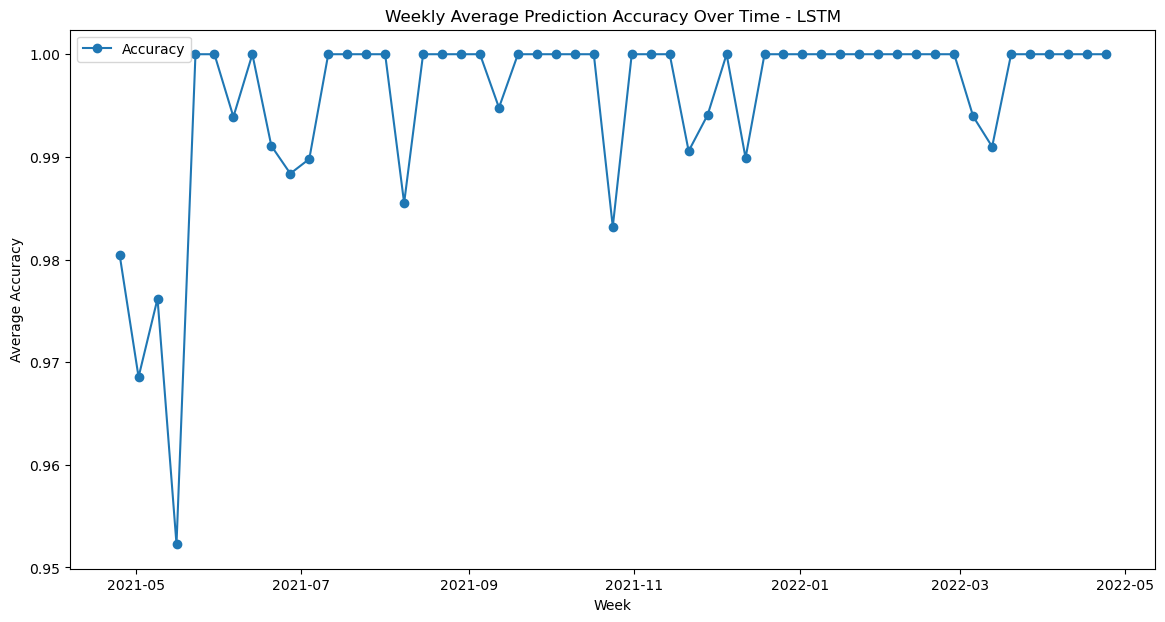

In [37]:
#Accuracy over Time - weekly
results_LSTM_df = pd.DataFrame({
    'event_date': log_data_encoded.loc[X_test.index, 'event_date'],  # Make sure this refers to the correct dates
    'actual_labels': actual_labels_LSTM,
    'predicted_labels': predicted_labels_LSTM
})

results_LSTM_df.index = pd.to_datetime(results_LSTM_df['event_date'])

# Create a new column to store whether each prediction was correct
results_LSTM_df['correct_prediction'] = (results_LSTM_df['actual_labels'] == results_LSTM_df['predicted_labels']).astype(int)

# Calculate weekly accuracy by taking the mean of 'correct_prediction'
weekly_accuracy_LSTM = results_LSTM_df['correct_prediction'].resample('W').mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy_LSTM.index, weekly_accuracy_LSTM, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time - LSTM')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score      support
0              0.904494  1.000000  0.949853   161.000000
1              1.000000  0.984568  0.992224   324.000000
2              1.000000  0.983753  0.991810  1908.000000
3              0.996103  0.991053  0.993572  3353.000000
4              0.978912  1.000000  0.989343  1439.000000
5              0.988764  1.000000  0.994350   440.000000
accuracy       0.991344  0.991344  0.991344     0.991344
macro avg      0.978046  0.993229  0.985192  7625.000000
weighted avg   0.991642  0.991344  0.991397  7625.000000


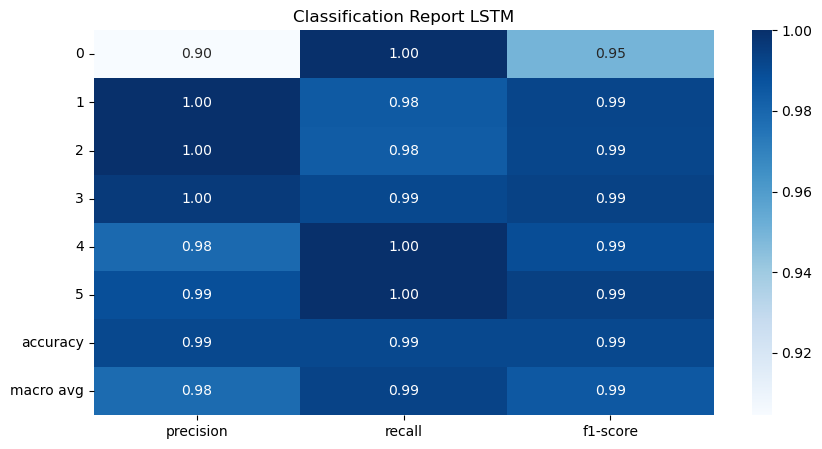

In [38]:
# Classification report
report_LSTM = classification_report(actual_classes_LSTM, y_pred_classes_LSTM, output_dict=True)
report_LSTM_df = pd.DataFrame(report_LSTM).transpose()
print(report_LSTM_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_LSTM_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report LSTM')
plt.show()

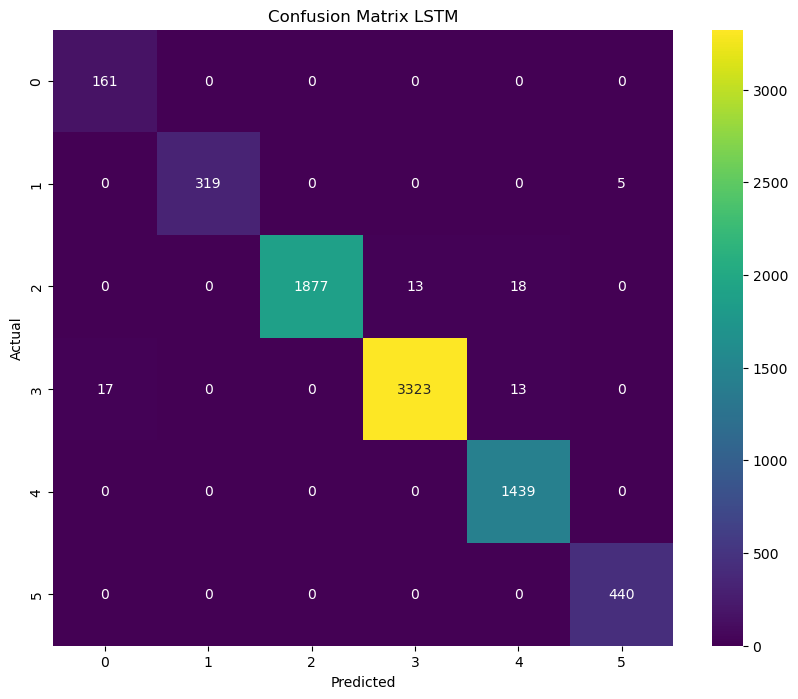

In [39]:
#Confusion Matrix
conf_matrix_LSTM = confusion_matrix(actual_classes_LSTM, y_pred_classes_LSTM)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_LSTM, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

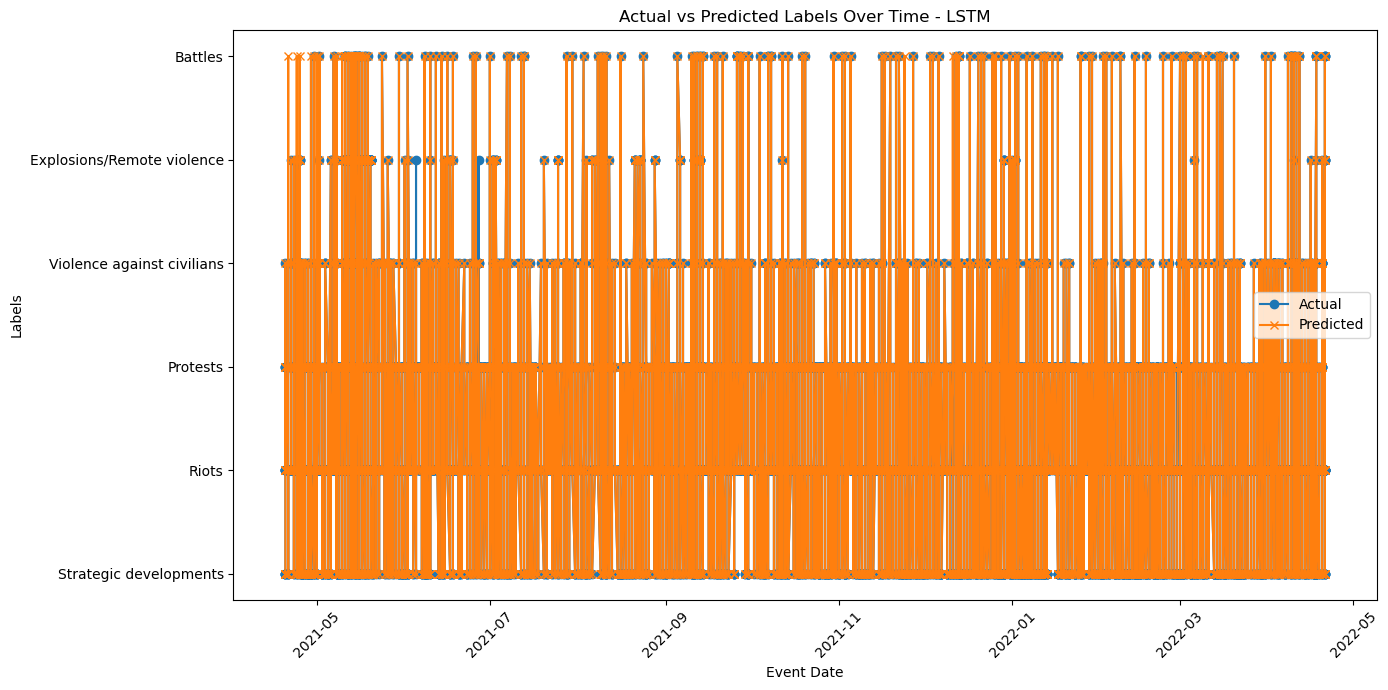

In [40]:
#Time-Series Plot
if 'event_date' in data.columns:
    event_dates_test = data.loc[X_test.index, 'event_date']
    results_LSTM_df = pd.DataFrame({
        'event_date': event_dates_test,
        'actual_labels': label_encoders['event_type'].inverse_transform(actual_classes_LSTM),
        'predicted_labels': label_encoders['event_type'].inverse_transform(y_pred_classes_LSTM)
    })
    results_LSTM_df.sort_values('event_date', inplace=True)

    plt.figure(figsize=(14, 7))
    plt.plot(results_LSTM_df['event_date'], results_LSTM_df['actual_labels'], label='Actual', marker='o')
    plt.plot(results_LSTM_df['event_date'], results_LSTM_df['predicted_labels'], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Labels Over Time - LSTM')
    plt.xlabel('Event Date')
    plt.ylabel('Labels')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [41]:
# LSTM Model without embedding
model_noembed = Sequential()
model_noembed.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_noembed.add(Dropout(0.2))
model_noembed.add(LSTM(50))
model_noembed.add(Dropout(0.2))
model_noembed.add(Dense(y_train_encoded.shape[1], activation='softmax'))

model_noembed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model_noembed.fit(X_train, y_train_encoded, epochs=25, batch_size=32, validation_split=0.1)


Epoch 1/25


2024-04-28 22:33:20.320518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:33:20.623228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:33:20.934565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:33:21.063888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:33:21.193538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


858/858 [==============================] - ETA: 0s - loss: 0.5829 - accuracy: 0.7884

2024-04-28 22:33:41.663215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:33:41.741232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:33:41.799983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


858/858 [==============================] - 24s 25ms/step - loss: 0.5829 - accuracy: 0.7884 - val_loss: 0.0334 - val_accuracy: 0.9925
Epoch 2/25
858/858 [==============================] - 18s 21ms/step - loss: 0.1056 - accuracy: 0.9682 - val_loss: 0.0280 - val_accuracy: 0.9938
Epoch 3/25
858/858 [==============================] - 24s 28ms/step - loss: 0.0391 - accuracy: 0.9879 - val_loss: 0.0218 - val_accuracy: 0.9951
Epoch 4/25
858/858 [==============================] - 20s 23ms/step - loss: 0.0221 - accuracy: 0.9937 - val_loss: 0.0049 - val_accuracy: 0.9990
Epoch 5/25
858/858 [==============================] - 19s 23ms/step - loss: 0.0164 - accuracy: 0.9953 - val_loss: 0.0080 - val_accuracy: 0.9984
Epoch 6/25
858/858 [==============================] - 19s 22ms/step - loss: 0.0149 - accuracy: 0.9954 - val_loss: 0.0041 - val_accuracy: 0.9990
Epoch 7/25
858/858 [==============================] - 56s 65ms/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 0.0032 - val_accuracy: 0.9990
Epo

In [42]:
loss_noembed, accuracy_noembed = model_noembed.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy Noembed: {accuracy_noembed:.2f}')
# predictions
y_pred_noembed = model_noembed.predict(X_test)
y_pred_classes_noembed = np.argmax(y_pred_noembed, axis=1)

#actual class
actual_classes_noembed = np.argmax(y_test_encoded, axis=1) if y_test_encoded.ndim > 1 else y_test

#showing errors
errors_noembed = np.where(y_pred_classes_noembed != actual_classes_noembed)[0]
print(f'Number of errors noembed: {len(errors_noembed)} / {len(actual_classes_noembed)}')
for i in errors_noembed[:10]:  # first 10 
    print(f'Index: {i}, Predicted: {y_pred_classes_noembed[i]}, Actual: {actual_classes_noembed[i]}')

239/239 [==============================] - 3s 13ms/step - loss: 0.4594 - accuracy: 0.8889
Test Accuracy Noembed: 0.89
  1/239 [..............................] - ETA: 1:33

2024-04-28 22:42:22.888420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:42:22.973649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 22:42:23.018006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 2s 6ms/step
Number of errors noembed: 847 / 7625
Index: 386, Predicted: 0, Actual: 1
Index: 4989, Predicted: 1, Actual: 3
Index: 4990, Predicted: 1, Actual: 3
Index: 4991, Predicted: 1, Actual: 3
Index: 4992, Predicted: 1, Actual: 3
Index: 4993, Predicted: 1, Actual: 3
Index: 5005, Predicted: 1, Actual: 3
Index: 5006, Predicted: 1, Actual: 3
Index: 5162, Predicted: 5, Actual: 3
Index: 5180, Predicted: 5, Actual: 3


In [43]:
predicted_labels_noembed = label_encoders['event_type'].inverse_transform(y_pred_classes_noembed)

actual_labels_noembed = label_encoders['event_type'].inverse_transform(actual_classes_noembed)

for actual, predicted in zip(actual_labels_noembed[:10], predicted_labels_noembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Riots, Predicted: Riots
Actual: Riots, Predicted: Riots
Actual: Explosions/Remote violence, Predicted: Explosions/Remote violence
Actual: Explosions/Remote violence, Predicted: Explosions/Remote violence
Actual: Strategic developments, Predicted: Strategic developments
Actual: Strategic developments, Predicted: Strategic developments
Actual: Riots, Predicted: Riots
Actual: Riots, Predicted: Riots
Actual: Explosions/Remote violence, Predicted: Explosions/Remote violence
Actual: Riots, Predicted: Riots


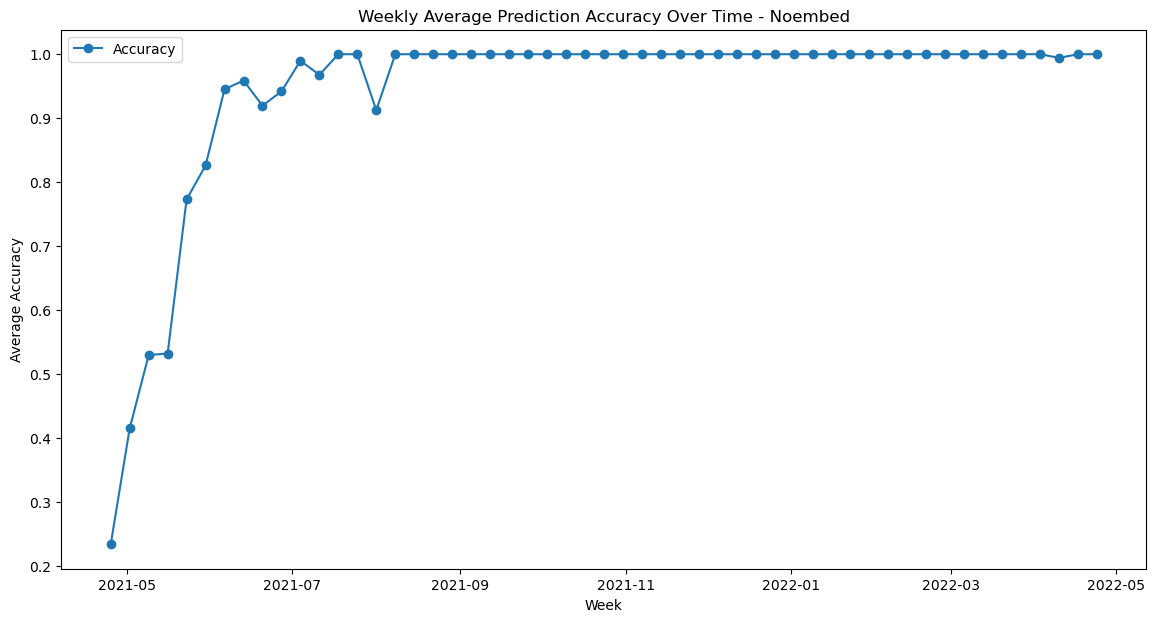

In [44]:
#Accuracy over Time - weekly
results_noembed_df = pd.DataFrame({
    'event_date': log_data_encoded.loc[X_test.index, 'event_date'],  # Make sure this refers to the correct dates
    'actual_labels': actual_labels_noembed,
    'predicted_labels': predicted_labels_noembed
})

results_noembed_df.index = pd.to_datetime(results_noembed_df['event_date'])

# Create a new column to store whether each prediction was correct
results_noembed_df['correct_prediction'] = (results_noembed_df['actual_labels'] == results_noembed_df['predicted_labels']).astype(int)

# Calculate weekly accuracy by taking the mean of 'correct_prediction'
weekly_accuracy_noembed = results_noembed_df['correct_prediction'].resample('W').mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy_noembed.index, weekly_accuracy_noembed, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time - Noembed')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score      support
0              0.297048  1.000000  0.458037   161.000000
1              0.906780  0.990741  0.946903   324.000000
2              1.000000  0.877883  0.934971  1908.000000
3              1.000000  0.822249  0.902455  3353.000000
4              0.896226  0.990271  0.940905  1439.000000
5              0.620934  0.997727  0.765475   440.000000
accuracy       0.888918  0.888918  0.888918     0.888918
macro avg      0.786831  0.946478  0.824791  7625.000000
weighted avg   0.939738  0.888918  0.902448  7625.000000


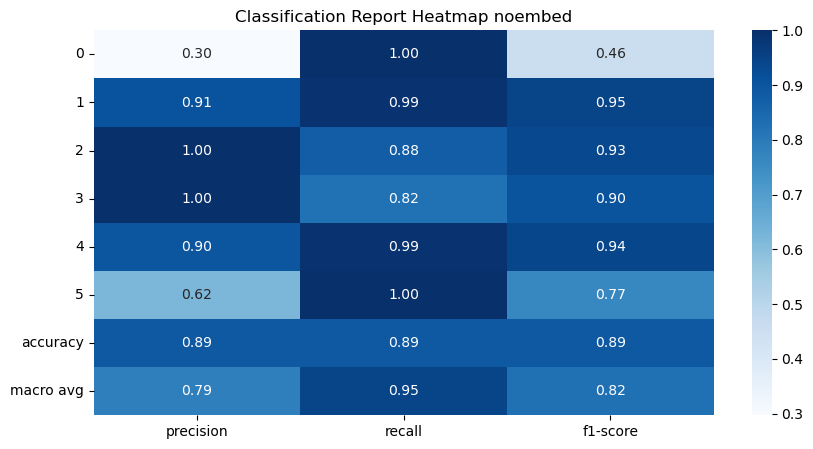

In [45]:
# Classification report
report_noembed = classification_report(actual_classes_noembed, y_pred_classes_noembed, output_dict=True)
report_noembed_df = pd.DataFrame(report_noembed).transpose()
print(report_noembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(report_noembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap noembed')
plt.show()

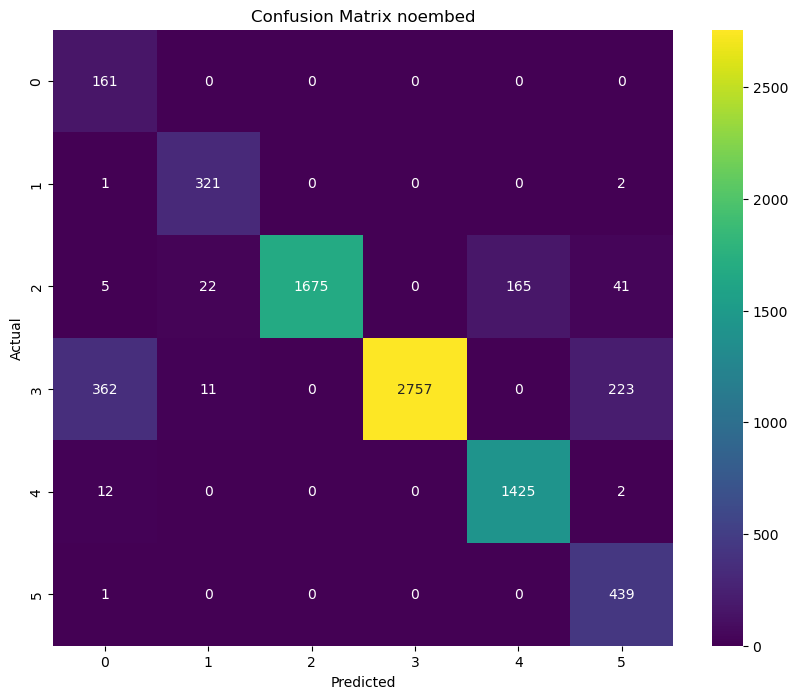

In [46]:
#Confusion Matrix
conf_matrix_noembed = confusion_matrix(actual_classes_noembed, y_pred_classes_noembed)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_noembed, annot=True, fmt='d', cmap='viridis')  # 'd' for integer format
plt.title('Confusion Matrix noembed')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

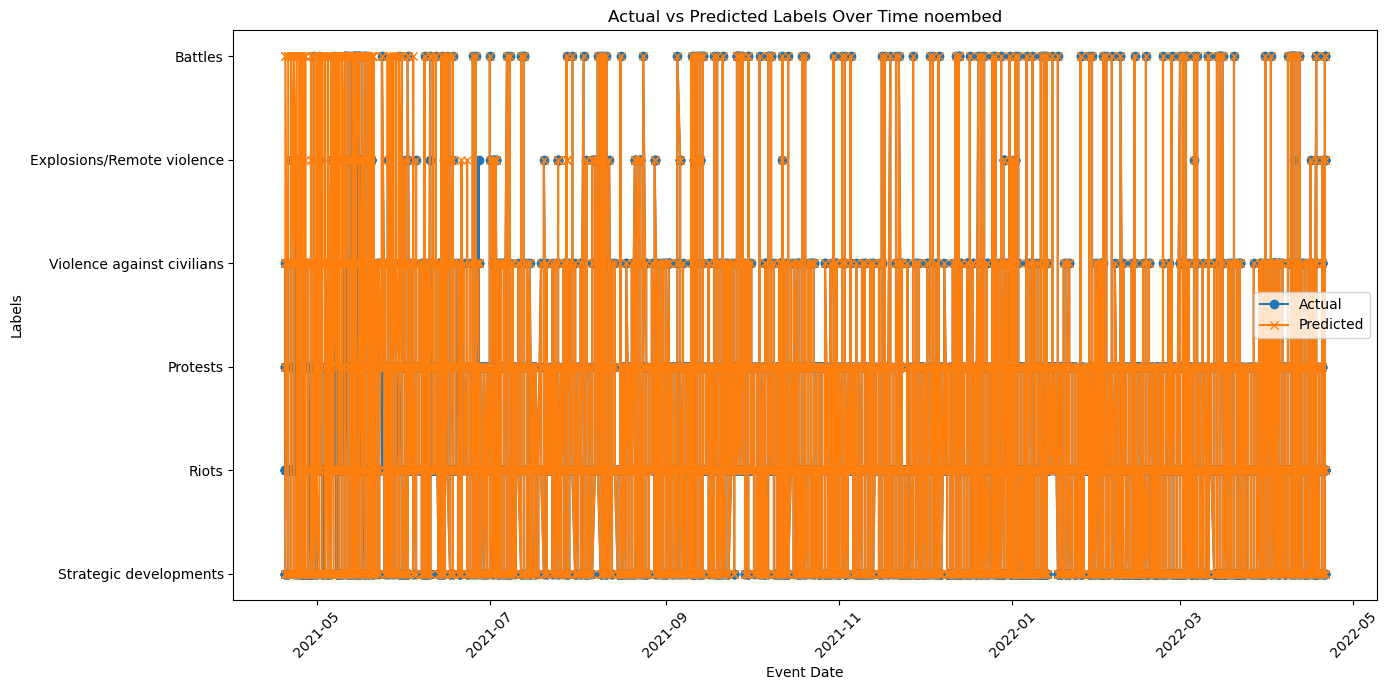

In [47]:
#Time-Series Plot
if 'event_date' in data.columns:
    event_dates_test_noembed = data.loc[X_test.index, 'event_date']
    results_noembed_df = pd.DataFrame({
        'event_date': event_dates_test_noembed,
        'actual_labels': label_encoders['event_type'].inverse_transform(actual_classes_noembed),
        'predicted_labels': label_encoders['event_type'].inverse_transform(y_pred_classes_noembed)
    })
    results_noembed_df.sort_values('event_date', inplace=True)
    
    plt.figure(figsize=(14, 7))
    plt.plot(results_noembed_df['event_date'], results_noembed_df['actual_labels'], label='Actual', marker='o')
    plt.plot(results_noembed_df['event_date'], results_noembed_df['predicted_labels'], label='Predicted', marker='x')
    plt.title('Actual vs Predicted Labels Over Time noembed')
    plt.xlabel('Event Date')
    plt.ylabel('Labels')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [48]:
#Creating OG Dataset (NO FEATURE SELECTION DATASET)

In [49]:
X_original = log_data_encoded.drop(['event_type', 'event_date', 'source', 'notes'], axis=1)
y_original = log_data_encoded['event_type']

X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42, shuffle=False)
y_original_train_encoded = tf.keras.utils.to_categorical(y_original_train)
y_original_test_encoded = tf.keras.utils.to_categorical(y_original_test)

In [50]:
print(X_original_train.shape)
print(X_original_test.shape)
print(y_original_train.shape)
print(y_original_test.shape)
print("Encoded Y")
print(y_original_train_encoded.shape)
print(y_original_test_encoded.shape)
#print(X_original_train.dtypes)

(30500, 167)
(7625, 167)
(30500,)
(7625,)
Encoded Y
(30500, 6)
(7625, 6)


In [52]:
# LSTM Model without embedding and NOT ON SELECTED FEATURES
og_model_noembed = Sequential()
og_model_noembed.add(LSTM(50, return_sequences=True, input_shape=(X_original_train.shape[1], 1)))
og_model_noembed.add(Dropout(0.2))
og_model_noembed.add(LSTM(50))
og_model_noembed.add(Dropout(0.2))
og_model_noembed.add(Dense(y_original_train_encoded.shape[1], activation='softmax'))

og_model_noembed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
og_model_noembed.fit(X_original_train, y_original_train_encoded, epochs=25, batch_size=32, validation_split=0.1)

Epoch 1/25


2024-04-28 23:13:28.607510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 23:13:29.397869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 23:13:29.798315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 23:13:30.172212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 23:13:30.466573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


858/858 [==============================] - ETA: 0s - loss: 1.3787 - accuracy: 0.4631

2024-04-28 23:14:00.604458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 23:14:00.697061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 23:14:00.768071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


858/858 [==============================] - 35s 37ms/step - loss: 1.3787 - accuracy: 0.4631 - val_loss: 1.3277 - val_accuracy: 0.4659
Epoch 2/25
858/858 [==============================] - 26s 31ms/step - loss: 0.7666 - accuracy: 0.7334 - val_loss: 0.3747 - val_accuracy: 0.9128
Epoch 3/25
858/858 [==============================] - 27s 31ms/step - loss: 0.5300 - accuracy: 0.8226 - val_loss: 0.2136 - val_accuracy: 0.9682
Epoch 4/25
858/858 [==============================] - 36s 42ms/step - loss: 0.3724 - accuracy: 0.8711 - val_loss: 0.2191 - val_accuracy: 0.9197
Epoch 5/25
858/858 [==============================] - 27s 31ms/step - loss: 0.2607 - accuracy: 0.9067 - val_loss: 0.0594 - val_accuracy: 0.9859
Epoch 6/25
858/858 [==============================] - 26s 31ms/step - loss: 0.2139 - accuracy: 0.9251 - val_loss: 0.0541 - val_accuracy: 0.9856
Epoch 7/25
858/858 [==============================] - 26s 30ms/step - loss: 0.1871 - accuracy: 0.9364 - val_loss: 0.0450 - val_accuracy: 0.9869
Epo

In [53]:
# Evaluate the model
og_loss_noembed, og_accuracy_noembed = og_model_noembed.evaluate(X_original_test, y_original_test_encoded)
print(f'Test Accuracy for original non-embedding model: {og_accuracy_noembed:.2f}')

# predictions
og_y_pred_noembed = og_model_noembed.predict(X_original_test)
og_y_pred_classes_noembed = np.argmax(og_y_pred_noembed, axis=1)

#actual class
og_actual_classes_noembed = np.argmax(y_original_test_encoded, axis=1)

#showing errors
og_errors_noembed = np.where(og_y_pred_classes_noembed != og_actual_classes_noembed)[0]
print(f'Number of errors in original non-embedding model: {len(og_errors_noembed)} / {len(og_actual_classes_noembed)}')
for i in og_errors_noembed[:10]:  # first 10 
    print(f'Index: {i}, Predicted: {og_y_pred_classes_noembed[i]}, Actual: {og_actual_classes_noembed[i]}')

239/239 [==============================] - 4s 16ms/step - loss: 1.3970 - accuracy: 0.4180
Test Accuracy for original non-embedding model: 0.42


2024-04-28 23:25:12.860869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 23:25:12.933502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-28 23:25:13.024672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 3s 10ms/step
Number of errors in original non-embedding model: 4438 / 7625
Index: 0, Predicted: 4, Actual: 3
Index: 1, Predicted: 4, Actual: 3
Index: 6, Predicted: 4, Actual: 3
Index: 7, Predicted: 4, Actual: 3
Index: 9, Predicted: 1, Actual: 3
Index: 10, Predicted: 4, Actual: 3
Index: 12, Predicted: 1, Actual: 0
Index: 13, Predicted: 1, Actual: 0
Index: 15, Predicted: 1, Actual: 0
Index: 16, Predicted: 4, Actual: 3


In [54]:
og_predicted_labels_noembed = label_encoders['event_type'].inverse_transform(og_y_pred_classes_noembed)

og_actual_labels_noembed = label_encoders['event_type'].inverse_transform(og_actual_classes_noembed)

for actual, predicted in zip(og_actual_labels_noembed[:10], og_predicted_labels_noembed[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")

Actual: Riots, Predicted: Strategic developments
Actual: Riots, Predicted: Strategic developments
Actual: Explosions/Remote violence, Predicted: Explosions/Remote violence
Actual: Explosions/Remote violence, Predicted: Explosions/Remote violence
Actual: Strategic developments, Predicted: Strategic developments
Actual: Strategic developments, Predicted: Strategic developments
Actual: Riots, Predicted: Strategic developments
Actual: Riots, Predicted: Strategic developments
Actual: Explosions/Remote violence, Predicted: Explosions/Remote violence
Actual: Riots, Predicted: Explosions/Remote violence


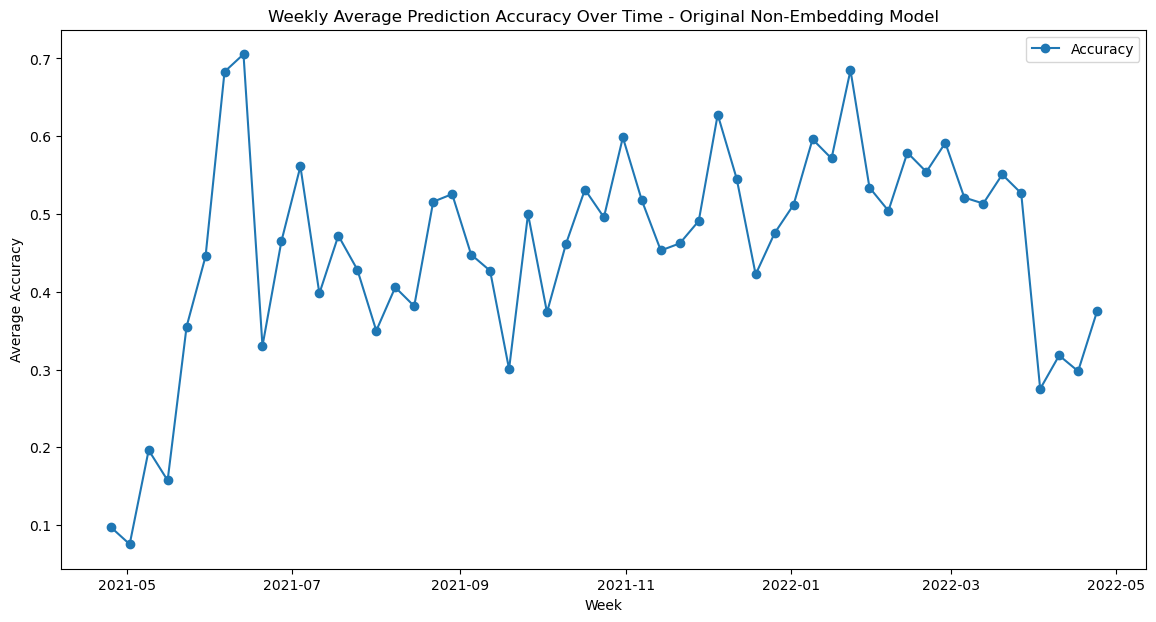

In [55]:
#Accuracy over Time - weekly
og_results_noembed_df = pd.DataFrame({
    'event_date': log_data_encoded.loc[X_original_test.index, 'event_date'],
    'actual_labels': og_actual_labels_noembed,  
    'predicted_labels': og_predicted_labels_noembed  
})

#datetime index
og_results_noembed_df.index = pd.to_datetime(og_results_noembed_df['event_date'])

#was each prediction was correct?
og_results_noembed_df['correct_prediction'] = (og_results_noembed_df['actual_labels'] == og_results_noembed_df['predicted_labels']).astype(int)

# weekly accuracy by taking the mean of 'correct_prediction'
weekly_accuracy_og_noembed = og_results_noembed_df['correct_prediction'].resample('W').mean()

plt.figure(figsize=(14, 7))
plt.plot(weekly_accuracy_og_noembed.index, weekly_accuracy_og_noembed, label='Accuracy', marker='o')
plt.title('Weekly Average Prediction Accuracy Over Time - Original Non-Embedding Model')
plt.xlabel('Week')
plt.ylabel('Average Accuracy')
plt.legend()
plt.show()

              precision    recall  f1-score      support
0              0.000000  0.000000  0.000000   161.000000
1              0.178998  0.462963  0.258176   324.000000
2              0.863511  0.822327  0.842416  1908.000000
3              0.965418  0.099911  0.181081  3353.000000
4              0.245079  0.787352  0.373804  1439.000000
5              0.000000  0.000000  0.000000   440.000000
accuracy       0.417967  0.417967  0.417967     0.417967
macro avg      0.375501  0.362092  0.275913  7625.000000
weighted avg   0.694464  0.417967  0.371941  7625.000000


/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Arya/miniforge3/envs/venv-metal/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

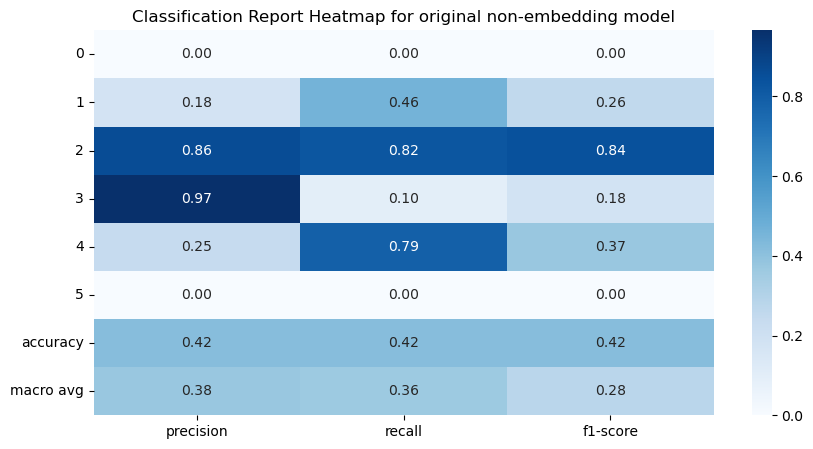

In [56]:
# Classification report
og_report_noembed = classification_report(og_actual_classes_noembed, og_y_pred_classes_noembed, output_dict=True)
og_report_noembed_df = pd.DataFrame(og_report_noembed).transpose()
print(og_report_noembed_df)

plt.figure(figsize=(10, 5))
sns.heatmap(og_report_noembed_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap="Blues")
plt.title('Classification Report Heatmap for original non-embedding model')
plt.show()

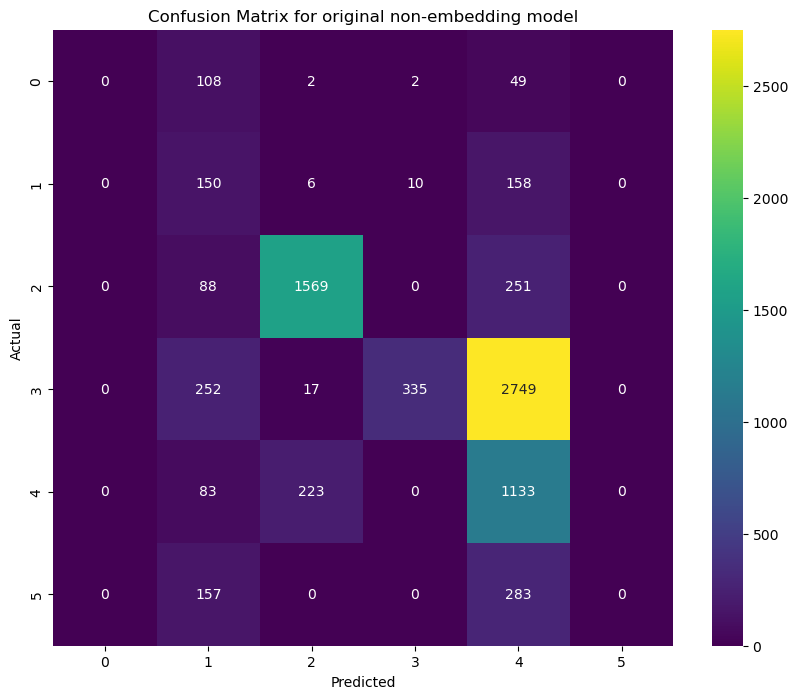

In [57]:
#Confusion Matrix
og_conf_matrix_noembed = confusion_matrix(og_actual_classes_noembed, og_y_pred_classes_noembed)
plt.figure(figsize=(10, 8))
sns.heatmap(og_conf_matrix_noembed, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix for original non-embedding model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

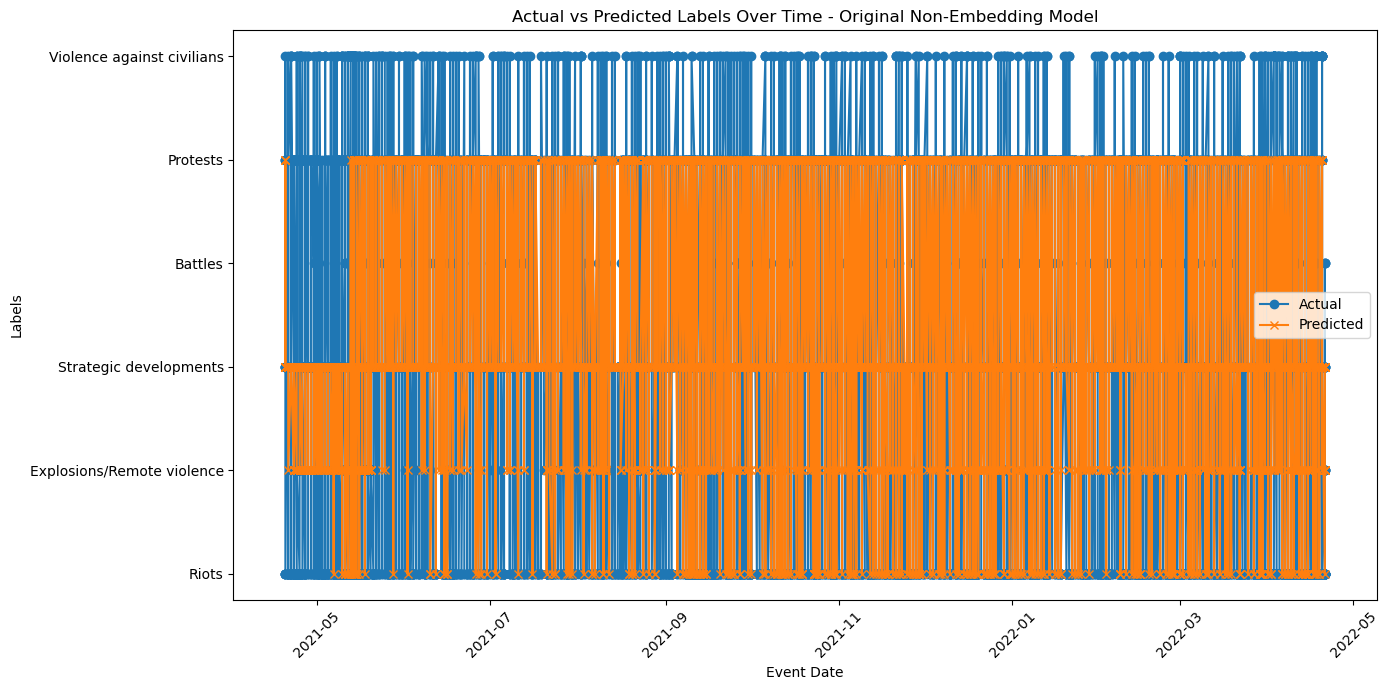

In [58]:
# Set 'event_date' as the index if it isn't already
if 'event_date' not in og_results_noembed_df.index.names:
    og_results_noembed_df.set_index('event_date', inplace=True)

# Convert the index to datetime if it's not already
og_results_noembed_df.index = pd.to_datetime(og_results_noembed_df.index)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(og_results_noembed_df.index, og_results_noembed_df['actual_labels'], label='Actual', marker='o')
plt.plot(og_results_noembed_df.index, og_results_noembed_df['predicted_labels'], label='Predicted', marker='x')
plt.title('Actual vs Predicted Labels Over Time - Original Non-Embedding Model')
plt.xlabel('Event Date')
plt.ylabel('Labels')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#VAR Model?

In [ ]:
#Prophet Model
from prophet import Prophet


In [ ]:
#ARIMA? #VECM? Need ONE MORE MODEL

In [ ]:
#Need to add plots for my paper. What types of plots can I create to convey my time-series prediction of 'event_type'?